# Geometric Tensor Learning
---

In [17]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
from sklearn.neighbors import kneighbors_graph
from omegaconf import OmegaConf
import os

import project_path

from util.visualize import plot_synthetic
from util.srpg import srpg_nnfold_modified as nnfold
from util.srpg import gmlsvd
from util.srpg import srpg_td_a as tda
from util.t2m import t2m
from util.m2t import m2t
from util.horpca import horpca
from util.hosvd import hosvd
from util.geoTL import geoTL
from util.geoTL import initialize_nograd
from util.update_Sigma import fn_val as fnval_Sigma
from util.generate_data import generate_smooth_stationary_data
from util.contaminate_data import contaminate_signal
from util.fn_vals import fn_val_L
from util.fn_vals import fn_val_G

In [18]:
md = loadmat('../data/coil_small.mat')
X = md['Data']

In [19]:
sizes = X.shape
n = len(sizes)
Phi = []
for i in range(n):
    A = kneighbors_graph(t2m(X,i), n_neighbors=int(np.log(sizes[i]),)).todense()
    A = (A+A.T)/2
    Phi.append(np.diag(np.array(np.sum(A,1)).squeeze())-A)

In [24]:
# Contaminate data.
Y = contaminate_signal(X, noise_rate=5)


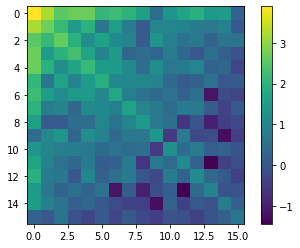

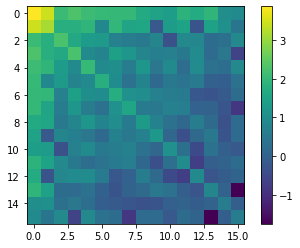

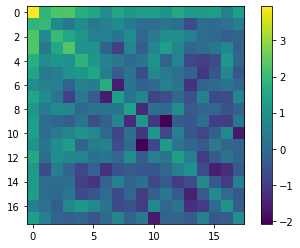

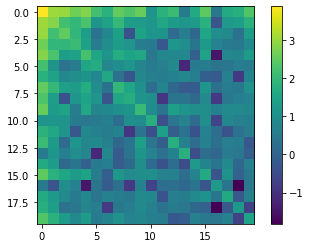

In [25]:
V = []
for i in range(n):
    v, S, _ = np.linalg.svd(Phi[i], hermitian=True)
    ind = np.argsort(S)
    V.append(v[:,ind])
    P_X = V[i].T @ t2m(X,i)
    psd = P_X@P_X.T
    plt.imshow(np.log10(abs(psd)))
    plt.colorbar()
    plt.show()

## The Algorithm

In below, we add noise to data and run our algorithm to recover the original signal back.

In [50]:
norm(X-L)/norm(X)

0.2936911492521164

In [6]:
for i in range(n):
    print('smoothness of the original data: {:.2f}'.format(np.trace(t2m(X,i).transpose()@Phi[i]@t2m(X,i))))
    print('smoothness of the noisy data: {:.2f}'.format(np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))))
    print('smoothness of the output: {:.2f}'.format(np.trace(t2m(X,i).transpose()@Phi[i]@t2m(X,i))))

smoothness of the original data: 958.18
smoothness of the noisy data: 1554.71
smoothness of the output: 958.18
smoothness of the original data: 855.36
smoothness of the noisy data: 1455.83
smoothness of the output: 855.36
smoothness of the original data: 635.11
smoothness of the noisy data: 1234.78
smoothness of the output: 635.11
smoothness of the original data: 1836.19
smoothness of the noisy data: 2434.99
smoothness of the output: 1836.19


In [7]:
## Examine Results
Let's see how our algorithm performed. Starting with normalized error from the original signal.

12.768146706520138
32.0
Ratio of degrees to off diagonal mismatch is: 2.5062368670669324
11.181408470106565
32.0
Ratio of degrees to off diagonal mismatch is: 2.8618934801954357
66.62186485084808
36.0
Ratio of degrees to off diagonal mismatch is: 0.5403631387472596
9.691608570908777
40.0
Ratio of degrees to off diagonal mismatch is: 4.127281834314654


In [8]:
L, G_var, Lx, X_t, Sigma, Lambda, gamma, theta, alpha = initialize_nograd(sizes)

In [9]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    y_smooth_val = np.trace(t2m(X,i).transpose()@Phi[i]@t2m(X,i))
    print('Ratio is (Y/X): {:.6f}'.format(x_smooth_val/y_smooth_val))

Ratio is (Y/X): 1.622561
Ratio is (Y/X): 1.702012
Ratio is (Y/X): 1.944196
Ratio is (Y/X): 1.326114


In [10]:

Y_rep = [Y.data for i in range(n)]
gamma = np.tile(5.,4)
theta = np.tile(1e-1,4)

var_y = np.var(Y.data)
d = 2
for i in range(n):
    gamma[i] *= var_y*(sizes[i]**2)/(25*d**2)
    theta[i] *= (sizes[i]**4)/((d**4)*(10**7))
y_sigma = [t2m(Y.data,i)@t2m(Y.data,i).transpose() for i in range(n)]
y_smooth_val = fn_val_G(Y_rep, Y.data, Phi, Lambda[0], alpha[0], gamma)[1]
comm_y = fnval_Sigma(y_sigma, Lx, X_t, Phi, Lambda[3], alpha[3], theta)[1]
for i in range(n):
    print('The smoothness value for Y at mode {} is: {:.4f}'.format(i,y_smooth_val[i])
    )
    print('The commutativity value for Y at mode {} is: {:.4f}'.format(i,comm_y[i])
    )



The smoothness value for Y at mode 0 is: 795.2012
The commutativity value for Y at mode 0 is: 42.2675
The smoothness value for Y at mode 1 is: 744.6275
The commutativity value for Y at mode 1 is: 40.8444
The smoothness value for Y at mode 2 is: 799.3283
The commutativity value for Y at mode 2 is: 7.2546
The smoothness value for Y at mode 3 is: 1946.0185
The commutativity value for Y at mode 3 is: 692.9400


In [11]:
# Function value for noisy Y
print('Smoothness value of noisy signal: {:.1e}'.format(sum(y_smooth_val)))
print('Commutivity value of noisy signal: {:.1e}'.format(sum(comm_y)))

Smoothness value of noisy signal: 4.3e+03
Commutivity value of noisy signal: 7.8e+02


In [12]:
# Function value for original X
X_rep = [X for _ in range(n)]
err_orig = fn_val_L(X, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X_t, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X,i)@t2m(X,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X_t, Phi, Lambda[3], alpha[3], theta)[1]

print('Error value of original signal: {:.1e}'.format(err_orig))
print('Smoothness value of original signal: {:.1e}'.format(sum(smooth_orig)))
print('Commutivity value of original signal: {:.1e}'.format(sum(comm_orig)))

Error value of original signal: 3.0e+02
Smoothness value of original signal: 2.8e+03
Commutivity value of original signal: 7.7e+02


In [13]:
L, obj_val, lam_val = geoTL(
    Y, Phi,
    gamma=gamma,
    theta=theta,
    alpha=alpha,
    max_iter=200,
    err_tol=1e-3,
    verbose=True
    )

Objective function changes for L: -6.93e+03, G: -2.58e+01, Lx: -9.85e+02, X: -1.48e+02, Sigma: -6.57e+01
Total Objective Function Value at iter 0: 1.656e+03
Objective function changes for L: -1.04e-01, G: -3.97e-01, Lx: -1.32e+02, X: -2.40e+02, Sigma: -1.32e+02
Total Objective Function Value at iter 1: 3.798e+03
Objective function changes for L: -8.23e+01, G: -5.74e-01, Lx: -9.86e+00, X: -4.95e+02, Sigma: -2.26e+02
Total Objective Function Value at iter 2: 6.759e+03
Objective function changes for L: -6.23e+01, G: -4.16e-01, Lx: -1.63e+01, X: -5.97e+02, Sigma: -2.95e+02
Total Objective Function Value at iter 3: 9.459e+03
Objective function changes for L: -2.81e+01, G: -2.30e-01, Lx: -2.15e+01, X: -6.47e+02, Sigma: -3.20e+02
Total Objective Function Value at iter 4: 1.137e+04
Objective function changes for L: -1.77e+01, G: -1.75e-01, Lx: -6.21e+01, X: -7.57e+02, Sigma: -3.08e+02
Total Objective Function Value at iter 5: 1.234e+04
Objective function changes for L: -1.22e+01, G: -1.14e-01,

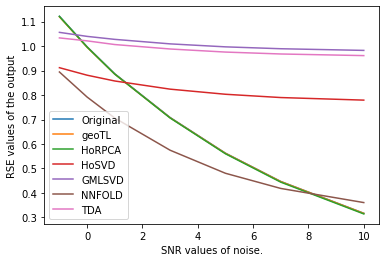

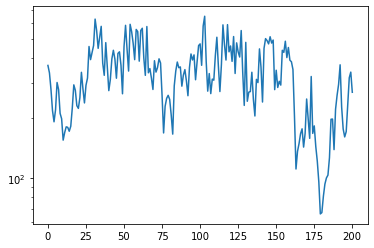

In [14]:
plt.semilogy(lam_val)

In [15]:
# ranks = np.int16(np.array(sizes)*1/4)
# std_Y = np.std(Y)
# alpha = [10**-3 for i in range(n)]
# L, obj_val, terms, lam_val = horpca(Y, alpha=alpha, max_iter=500, err_tol=1e-2)
# L,_,_,_ = hosvd(X, ranks, max_iter=30, err_tol=1e-3)
# L = gmlsvd(Y, Phi, ranks)
# L, obj_val, lam_val = nnfold(
#                     Y, Phi,
#                     alpha=np.tile(0.5/np.sqrt(np.max(sizes)), n),
#                     beta=np.tile(0.5/np.sqrt(np.max(sizes)), n),
#                     max_iter=500, err_tol=0.01)

# L, obj_val = tda(Y, Phi, ranks, lamda=0.01, gamma=0.00001, max_iter=30, verbose=True)

## Examine Results
Let's see how our algorithm performed. Starting with normalized error from the original signal.

In [17]:
print('Normalized error of the output: {:.2f}'.format(norm(X-L)/norm(X)))
print('Normalized error of the input: {:.2f}'.format(norm(X-Y.data)/norm(X)))


Normalized error of the output: 0.30
Normalized error of the input: 0.18


In [140]:
for i in range(n):
    x_smooth_val = np.trace(t2m(X,i).transpose()@Phi[i]@t2m(X,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for X is: {:.2f}, while for L it is: {:.2f}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (X/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for X is: 958.18, while for L it is: 746.84
Ratio is (X/L): 1.282982
The smoothness value for X is: 855.36, while for L it is: 621.54
Ratio is (X/L): 1.376196
The smoothness value for X is: 635.11, while for L it is: 604.60
Ratio is (X/L): 1.050467
The smoothness value for X is: 1836.19, while for L it is: 1245.77
Ratio is (X/L): 1.473943


In [141]:
for i in range(n):
    x_smooth_val = np.trace(t2m(Y.data,i).transpose()@Phi[i]@t2m(Y.data,i))
    l_smooth_val = np.trace(t2m(L,i).transpose()@Phi[i]@t2m(L,i))
    print('The smoothness value for Y is: {:.4e}, while for L it is: {:.4e}'.format(
        x_smooth_val,
        l_smooth_val
        )
    )
    print('Ratio is (Y/L): {:.6f}'.format(x_smooth_val/l_smooth_val))

The smoothness value for Y is: 1.5522e+03, while for L it is: 7.4684e+02
Ratio is (Y/L): 2.078412
The smoothness value for Y is: 1.4517e+03, while for L it is: 6.2154e+02
Ratio is (Y/L): 2.335696
The smoothness value for Y is: 1.2336e+03, while for L it is: 6.0460e+02
Ratio is (Y/L): 2.040301
The smoothness value for Y is: 2.4415e+03, while for L it is: 1.2458e+03
Ratio is (Y/L): 1.959876


In [142]:
# Plot stationarity for Y
for i in range(n):
    P_Y = V[i].transpose()@t2m(Y.data,i)
    cov = t2m(Y.data,i)@t2m(Y.data,i).transpose()
    psd_y = np.array(P_Y@P_Y.transpose())
    psd_off_diag = norm(psd_y.ravel(), ord=1) - np.trace(psd_y)
    print(psd_off_diag)
    cov_off_diag = norm(cov.ravel(), ord=1) - np.trace(cov)
    print(cov_off_diag)
    print(cov_off_diag/psd_off_diag)
    print(np.trace(Phi[i]))
    # plt.imshow(np.log10(abs(psd_y)))
    # plt.colorbar()
    # plt.show()

9133.011318407427
116460.69689565153
12.75162077823412
32.0
9603.579820561376
108705.76831918905
11.319296590470227
32.0
2233.805625648598
148540.5965667982
66.49665255618139
36.0
14437.13518507487
140238.75233577882
9.713752107880643
40.0


In [126]:
# # Plot stationarity for L
# for i in range(n):
#     P_L = V[i].transpose()@t2m(L,i)
#     cov = P_L@P_L.transpose()
#     plt.imshow(np.log10(abs(cov)))
#     plt.colorbar()
#     plt.show()

In [127]:
# plt.semilogy(fval_tot[7:]-min(fval_tot[7:]))
# plt.show()

In [128]:
# Function value for original X
X_rep = [X for i in range(n)]
err_orig = fn_val_L(X, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_orig = fn_val_G(X_rep, X, Phi, Lambda[0], alpha[0], gamma)[1]
x_sigma = [t2m(X,i)@t2m(X,i).transpose() for i in range(n)]
comm_orig = fnval_Sigma(x_sigma, Lx, X_t, Phi, Lambda[3], alpha[3], theta)[1]

orig_fn_val = sum(err_orig + smooth_orig + comm_orig)
print('Function value of original signal: {:.1e}'.format(orig_fn_val))

Function value of original signal: 1.6e+03


In [129]:
# Function value for learned L
L_rep = [L for _ in range(n)]
err_l = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[1]
smooth_l = fn_val_G(L_rep, L, Phi, Lambda[0], alpha[0], gamma)[1]
l_sigma = [t2m(L,i)@t2m(L,i).transpose() for i in range(n)]
comm_l = fnval_Sigma(l_sigma, Lx, X_t, Phi, Lambda[3], alpha[3], theta)[1]

l_fn_val = sum(err_l + smooth_l + comm_l)
print('Function value of the output signal: {:.1e}'.format(l_fn_val))

Function value of the output signal: 1.4e+03


In [130]:
print(err_orig)
print(err_l)

299.0797663948077
284.5305850339433


In [131]:
print(sum(smooth_orig))
print(sum(smooth_l))

383.9378309639202
280.5129192160466


In [132]:

# for i in range(cov.shape[0]):
#     for j in range(cov.shape[1]):
#         text = ax.text(j, i, np.round(np.log10(cov[i, j]), 2) ,
#                        ha="center", va="center", color="w")

7.204405110635918e-25
3.7089358129743406e-25
